In [1]:
using  Plots, Optim, Dates, DiffEqParamEstim, Flux, DiffEqFlux, OrdinaryDiffEq

In [2]:
# Start conditions for the two species in the system
u0 = Float32[1.; 2.]
# Number of evaluations of the neural ODE. It relates to the numbers of layers of the neural net (depth of network).
datasize = 300
# Time span in which of evaluation will be and actual timepoints of evaluations
tspan = (0.0f0, 50.f0)
t = range(tspan[1], tspan[2], length = datasize)
# The true ODE (with the true parameters) which the neural net should learn
function trueODEfunc(du, u, p, t)
    du[1]=u[1]*cos(t)
    du[2]=u[2]*cos(t)
end
# Construction of the ODEProblem and solving the ODEProblem with Tsit5 solver
prob = ODEProblem(trueODEfunc, u0, tspan)
ode_data = Array(solve(prob,Tsit5(),saveat=t))
plot(ode_data')
species1 = "1"
species2 = "2";

In [4]:
# Structure to observe training
mutable struct saver
    losses::Array{Float64,1}
    times::Array{Dates.Time,1}
    count_epochs::Int128
end
function saver(n_epochs)
    losses = zeros(n_epochs)
    times = fill(Dates.Time(Dates.now()),n_epochs)
    count_epochs = 0
    return saver(losses,times,count_epochs)
end
function update_saver(saver, loss_i, time_i)
    epoch_i = saver.count_epochs
    saver.losses[epoch_i] = loss_i
    saver.times[epoch_i] = time_i
end

update_saver (generic function with 1 method)

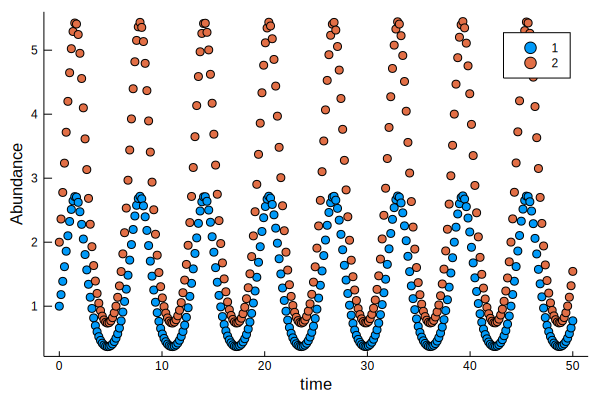

In [5]:
scatter(t, ode_data[1,:], grid = "off", xlab = "time", ylab = "Abundance", label = species1 )
scatter!(t, ode_data[2,:], label = species2 )

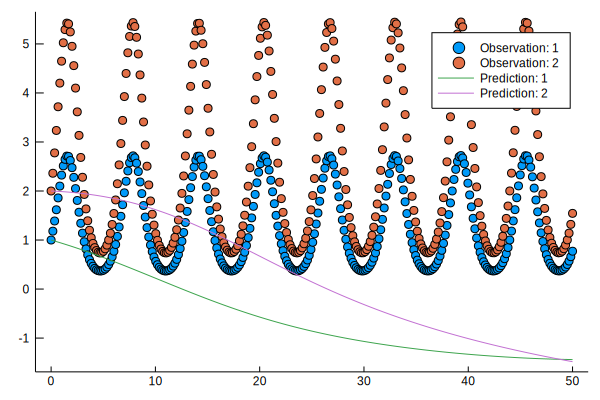

In [6]:
# Building a neural ODE and see starting point
# Derivative is modeled by a neural net. Chain concatinates the functions ode function and two dense layers.
dudt = Chain(Dense(2,100, tanh),
       Dense(100,100, tanh),
       Dense(100,100, tanh),
       Dense(100,2))
# Parameters of the model which are to be learnt. They are: W1 (2x50), b1 (50), W2 (50x2), b2 (2)
ps = Flux.params(dudt)
# Defining anonymous function for the neural ODE with the model. in: u0, out: solution with current params.
n_ode = x->neural_ode(dudt, x, tspan, Tsit5(), saveat = t, reltol = 1e-7, abstol = 1e-9)
n_epochs = 200
sa_l2 = saver(n_epochs)
# L2 loss
L2_loss_fct() = sum(abs2, ode_data .- n_ode(u0))
# Callback function to observe L2 training.
cb = function ()
    sa_l2.count_epochs = sa_l2.count_epochs +  1
    update_saver(sa_l2, Tracker.data(L2_loss_fct()), Dates.Time(Dates.now()))
    #println("\"", Tracker.data(L2_loss_fct()), "\" \"", Dates.Time(Dates.now()), "\";")
end

pred = n_ode(u0)
scatter(t, ode_data[1,:], label = string("Observation: ", species1), grid = "off")
scatter!(t, ode_data[2,:], label = string("Observation: ", species2))
plot!(t, Flux.data(pred[1,:]), label = string("Prediction: ", species1))
plot!(t, Flux.data(pred[2,:]), label = string("Prediction: ", species2))

In [7]:
# train n_ode with L2 norm
opt = ADAM(0.0001)
data = Iterators.repeated((), n_epochs)
@time Flux.train!(L2_loss_fct, ps, data, opt, cb = cb)

InterruptException: InterruptException:

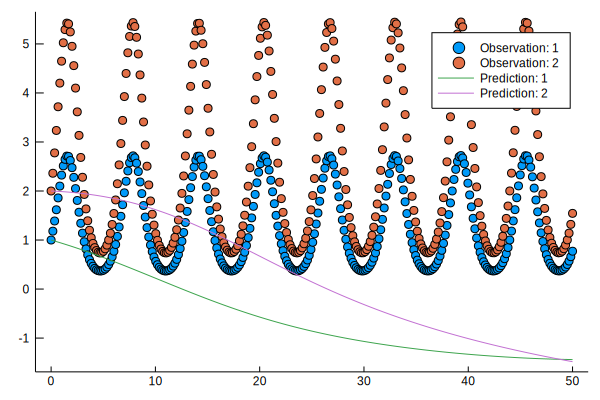

In [8]:
scatter(t, ode_data[1,:], label = string("Observation: ", species1), grid = "off")
scatter!(t, ode_data[2,:], label = string("Observation: ", species2))
plot!(t, Flux.data(pred[1,:]), label = string("Prediction: ", species1))
plot!(t, Flux.data(pred[2,:]), label = string("Prediction: ", species2))

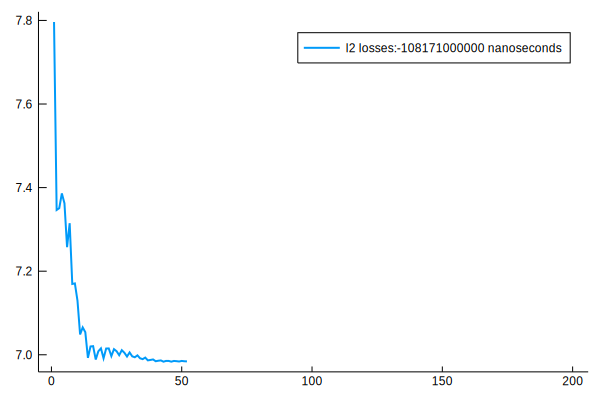

In [9]:
header = string("l2 losses:",sa_l2.times[end]-sa_l2.times[1])
plot(range(1, stop = length(sa_l2.losses)), log.(sa_l2.losses), width = 2, label = header, grid = "off")